In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [4]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
import Datasets.ModelData as md
from Transforms.ImageTransforms import *
import util

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 960M', True)

In [7]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [8]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [9]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [10]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [11]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [12]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [13]:
examples = pd.read_csv(DATA_PATH/'train_labels.csv')
images = split(examples, 'filename')

In [14]:
def print_example_from_data(filename, bbs, cats, ax=None):
    if ax is not None:
        show_img(im, ax=ax)
    else:
        ax = show_img(im)
        
    for bb,cat in zip(util.partition(bbs, 4), cats):
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cat)

In [15]:
def print_example(example, ax=None):
    im = ImageData.open_image(DATA_PATH/example.filename)
    if ax is not None:
        show_img(im, ax=ax)
    else:
        ax = show_img(im)
    for index, row in example.object.iterrows():
        bb = corners_to_hw([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) # Bounding box converted to height width
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], row['class']) 

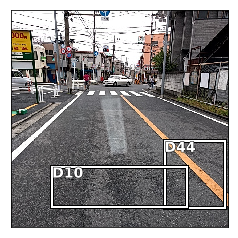

In [16]:
print_example(images[0])

In [17]:
im = ImageData.open_image(DATA_PATH/images[1].filename)

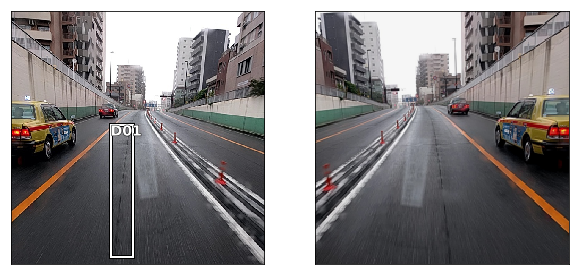

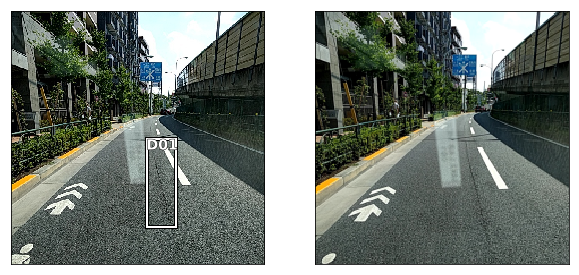

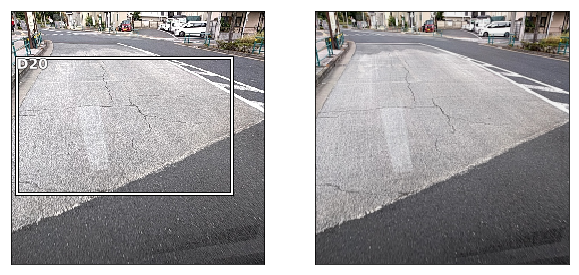

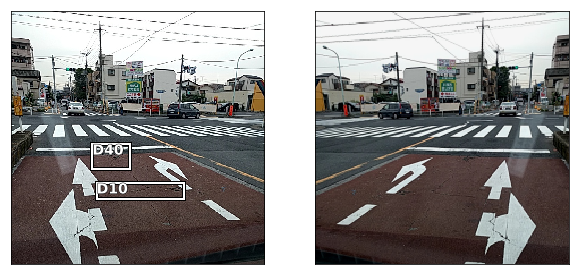

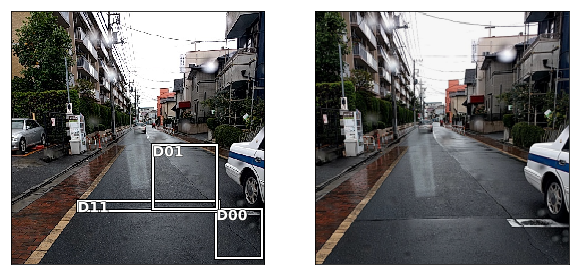

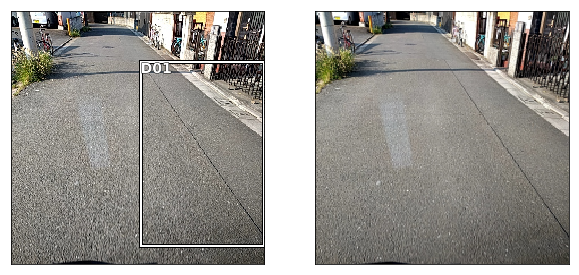

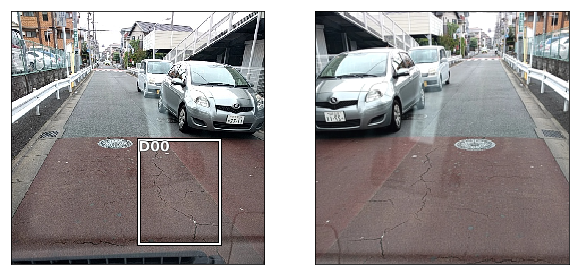

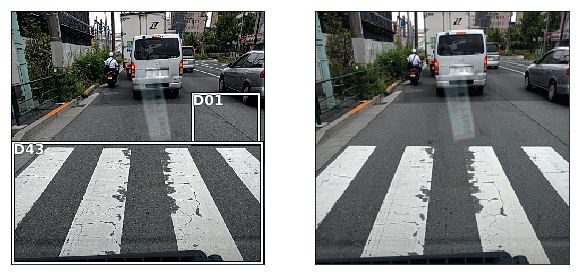

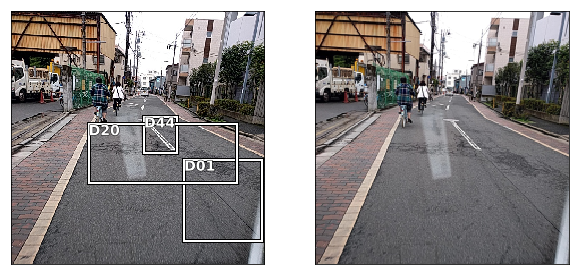

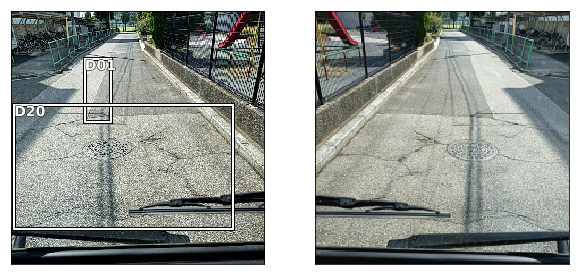

In [18]:
im_size = 224
test_tfms = TransformList([
        RandomScale(im_size, 1.2),
        RandomCrop(im_size),
        RandomLighting(0.05, 0.05),
        RandomHorizontalFlip()
])

for i in range(10, 20):
    f, ax = plt.subplots(1,2, figsize=(10, 10))
    print_example(images[i], ax[0])
    im = ImageData.open_image(DATA_PATH/images[i].filename) 
    ax[1].imshow(test_tfms(im, 0)[0])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)  

In [19]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [20]:
mc = [set([row['class'] for index, row in img.object.iterrows()]) for img in images]
mcs = [' '.join(label for label in labels) for labels in mc]
print(mc[0:4])
print(mcs[0:4])

[{'D10', 'D44'}, {'D01'}, {'D01'}, {'D00', 'D01'}]
['D10 D44', 'D01', 'D01', 'D00 D01']


In [21]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'class': mcs}, columns=['filename','class'])
df.to_csv(MULTICLASS_CSV_PATH, index=False)

In [22]:
MULTIBB_CSV_PATH = DATA_PATH/'bb.csv'

In [23]:
print(images[0].object)

                                      filename  width  height class  xmin  \
9382  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D44   424   
9383  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D10   114   

      ymin  xmax  ymax  
9382   361   590   546  
9383   432   487   543  


In [24]:
mbb = [np.concatenate([corners_to_hw([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) for index, row in img.object.iterrows()]) for img in images]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [25]:
mbbs

['424 361 166 185 114 432 373 111',
 '113 353 147 239 318 300 137 282',
 '474 344 124 149',
 '362 228 162 350 130 310 269 279',
 '88 381 79 74 84 282 242 54 272 356 213 181',
 '391 384 149 203 347 322 201 266 1 382 143 210',
 '16 325 167 141',
 '190 263 63 129 5 276 141 124',
 '146 288 120 188 363 301 231 231',
 '237 258 348 47 1 291 232 178',
 '236 269 53 314',
 '321 302 69 209',
 '14 111 509 323',
 '203 406 206 39 193 314 88 59',
 '486 469 107 116 158 450 335 24 335 318 152 150',
 '307 121 291 435',
 '302 306 192 246',
 '430 197 156 117 6 313 587 284',
 '410 352 185 193 315 250 79 86 184 268 352 140',
 '175 114 62 150 8 223 517 293',
 '150 312 328 32 452 438 148 107',
 '1 308 190 168 338 265 104 335',
 '437 467 145 124',
 '264 69 148 185',
 '345 232 75 243',
 '74 325 37 266',
 '514 483 86 94 23 277 86 225 103 311 91 121',
 '354 284 134 310',
 '392 455 206 69 104 381 255 218',
 '407 225 176 226 164 273 96 193',
 '330 336 264 241 305 387 86 82 10 400 83 196',
 '266 334 307 233 173 268 

In [26]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'bbox': mbbs}, columns=['filename','bbox'])
df.to_csv(MULTIBB_CSV_PATH, index=False)

In [27]:
df.head()

,filename,bbox
0,Adachi/JPEGImages/train_Adachi_00001.jpg,424 361 166 185 114 432 373 111
1,Adachi/JPEGImages/train_Adachi_00002.jpg,113 353 147 239 318 300 137 282
2,Adachi/JPEGImages/train_Adachi_00003.jpg,474 344 124 149
3,Adachi/JPEGImages/train_Adachi_00004.jpg,362 228 162 350 130 310 269 279
4,Adachi/JPEGImages/train_Adachi_00006.jpg,88 381 79 74 84 282 242 54 272 356 213 181


In [28]:
files = [str(DATA_PATH/img.filename) for img in images]

In [29]:
labels = [md.StructuredLabel([(np.array(bb.split(' ')).astype(np.float32), md.LabelType.BOUNDING_BOX), (cat, md.LabelType.CATEGORY)]) for bb, cat in zip(mbbs, mcs)]

In [30]:
labels[0]

[(array([424., 361., 166., 185., 114., 432., 373., 111.], dtype=float32),
  <LabelType.BOUNDING_BOX: 3>),
 ('D10 D44', <LabelType.CATEGORY: 1>)]

In [31]:
dataset = ImageData.ImageDataset(files, labels, test_tfms)

In [32]:
init_label = labels[0]

In [33]:
labels[0]

[(array([424., 361., 166., 185., 114., 432., 373., 111.], dtype=float32),
  <LabelType.BOUNDING_BOX: 3>),
 ('D10 D44', <LabelType.CATEGORY: 1>)]

In [34]:
im, new_label, *_ = dataset[0]

[424. 361. 166. 185. 114. 432. 373. 111.] LabelType.BOUNDING_BOX


In [35]:
print(init_label)

[(array([424., 361., 166., 185., 114., 432., 373., 111.], dtype=float32), <LabelType.BOUNDING_BOX: 3>), ('D10 D44', <LabelType.CATEGORY: 1>)]


In [36]:
print(new_label)

[([array([163.5, 139. ,  65. ,  72. ], dtype=float32), array([0., 0., 0., 0.], dtype=float32)], <LabelType.BOUNDING_BOX: 3>)]


In [37]:
print_example_from_data(im, new_label[0][0], new_label[1][0])

IndexError: list index out of range